# Access and Deprivation

The data used in this notebook can be found at [this link](https://drive.google.com/drive/folders/1kNZ90Q8cwMqmiBW4fKqkl9caIWy3dvGi?usp=share_link). File paths should be adjusted accordingly.

Created on Google Colabs.

## Packages

In [ ]:
!pip install numpy pandas geopandas seaborn matplotlib matplotlib_scalebar scikit-learn networkx cdlib contextily

import re
import os
import copy
from math import sqrt
from scipy.spatial import Delaunay
from scipy.stats.mstats import winsorize

# Adjusting pandas display
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

# Importing the installed packages
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib_scalebar.scalebar import ScaleBar

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import igraph as ig
from cdlib import NodeClustering

from matplotlib.pyplot import cm
from shapely.geometry import Point
from collections import defaultdict # to make sure dictionary copies are better mirrors of the origional
import contextily as ctx

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Preprocessing Census Data

In [ ]:
# path
folder_path = "YOUR_PATH_HERE/Data/2021 Census Features"

# List all files in the directory
all_files = os.listdir(folder_path)

# Get all the .csv files
csv_files = [file for file in all_files if file.endswith('.csv') or file.endswith('.CSV')]

# Print the list of CSV files
print("CSV files:")
print(csv_files)

# Create an empty list to hold dataframes
data_frames = []

# Loop over the list of csv files
for filename in csv_files:
    print(f"Loading file: {filename}")
    # Read CSV to dataframe
    df = pd.read_csv(os.path.join(folder_path, filename))
    # Append dataframe to the list
    data_frames.append(df)

# Print the number of dataframes
print(f"Loaded {len(data_frames)} dataframes.")

CSV files:
['Age2021.csv', 'Sex2021.csv', 'Disability2021.csv', 'Ethnicity2021.csv', 'Employment2021.csv', 'WorkDist2021.csv', 'HouseholdDep2021.csv', 'HouseholdType2021.csv', 'Cars2021.csv']
Loading file: Age2021.csv
Loading file: Sex2021.csv
Loading file: Disability2021.csv
Loading file: Ethnicity2021.csv
Loading file: Employment2021.csv
Loading file: WorkDist2021.csv
Loading file: HouseholdDep2021.csv
Loading file: HouseholdType2021.csv
Loading file: Cars2021.csv
Loaded 9 dataframes.


In [ ]:
# THIS IS SO I CAN CALC POPULATION DENSITY LATER TO USE FOR BASIC PTAL MEASURE
population = data_frames[8].groupby("Lower layer Super Output Areas Code")["Observation"].sum()
population_df = population.reset_index() # Convert the Series to a DataFrame
data_frames[8] = data_frames[8].merge(population_df, how="left", on='Lower layer Super Output Areas Code')
data_frames[8].rename(columns={"Observation_x": "Observation", "Observation_y": "Population"}, inplace=True)

## Create the Census Vector to Reflect Concentrations

The Python script below is built to amalgamate multiple csv files into a single dictionary for more streamlined data handling when used as a vector. It builds a dictionary of dictionaries. It begins by initialising a counter (cc_counter), a dictionary (data_dict) to store the final dataset, and a DataFrame (cc_origin) to record the original census category values and their corresponding 'cc' codes.

The script iterates over each CSV file from the input list. Each file is loaded into a DataFrame, and any column containing the word 'code' (except the 'Lower layer Super Output Areas Code') is singled out. For each unique value in these 'code' columns, a new 'cc' code is generated (unless it has already been assigned one). The 'cc' code and the corresponding original value, along with the file it originated from, are then stored in the cc_origin DataFrame for reference in subsequent analyses. **NOTE: depending on the csvs are stored locally, some adjustments to the code below will need to be made when specific census categories are referenced. This is also true if applying this code to different case studies**

Next, for each DataFrame, the code below computes the concentration of each demographic group for each LSOA, iterating over each row in the DataFrame. For each row, it checks if the corresponding 'Lower layer Super Output Areas Code' (LSOA code) exists in the dictionary, if not, it creates a new dictionary for that LSOA code. Then, for each 'code' column in the row, the script assigns the 'cc' code as the key and the corresponding 'z_score' value as the value in the dictionary corresponding to the LSOA code.

In the end, 'data_dict' contains a comprehensive dictionary with each LSOA code mapping to another dictionary of 'cc' codes and their corresponding 'z_score' values. The cc_origin DataFrame, on the other hand, provides a lookup table for what each 'cc' code refers to in the original dataset.

In [ ]:
# Prepare the population data
population_df = data_frames[8].copy()
population_df.set_index("Lower layer Super Output Areas Code", inplace=True)

# Dictionary to store total populations of each LSOA
total_population_by_lsoa = population_df['Population'].to_dict()

# Calculate the total population of all LSOAs (entire London)
total_population_london = sum(total_population_by_lsoa.values())

# Dictionary to store total counts of each observation type across all LSOAs
total_counts = {}

###########################################################################################

# Initialise a counter for generating cc codes, a dictionary to hold the data, and a dataframe to hold cc origins
cc_counter = 1
data_dict = {}
cc_origin = pd.DataFrame(columns=['cc', 'origin_info', 'filename'])

for idx, df in enumerate(data_frames):
    print(f"Loading DataFrame: {idx}")

    for col in df.columns:
        if 'code' in col.lower() and col != 'Lower layer Super Output Areas Code':
            df = df[df[col] != -8]

    # Extract column names containing 'categories)' and not 'code'
    code_columns = [col for col in df.columns if 'categories)' in col.lower() and 'code' not in col.lower()]

    # Update total counts for each observation type
    for col in code_columns:
        for code, count in df[df['Observation'] != 0].groupby(col)['Observation'].sum().items():
            total_counts[code] = total_counts.get(code, 0) + count

    # Generate 'cc' codes and store in the cc_origin dataframe
    code_to_cc = {}
    for col in code_columns:
        for code in df[col].unique():
            if code not in code_to_cc:
                cc_code = 'cc' + str(cc_counter)
                code_to_cc[code] = cc_code
                cc_counter += 1

                # Add to cc_origin dataframe
                cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)

    # Special handling for the population DataFrame
    if idx == 8:
        # Assign a 'cc' for the population column
        population_cc = 'cc' + str(cc_counter)
        cc_counter += 1

        # Add to cc_origin dataframe
        cc_origin = cc_origin.append({'cc': population_cc, 'origin_info': 'population', 'filename': idx}, ignore_index=True)

    for i, row in df.iterrows():
        lsoa_code = row['Lower layer Super Output Areas Code']

        # If this code isn't in the dictionary yet, add it
        if lsoa_code not in data_dict:
            data_dict[lsoa_code] = {'census': {}}

        for col in code_columns:
            observation_type = row[col]
            cc_code = code_to_cc[observation_type]

            # If observation is zero, assign concentration as zero
            if row['Observation'] == 0:
                data_dict[lsoa_code]['census'][cc_code] = 0
            else:
                # Numerator: observation of group x in this LSOA / total population of this LSOA
                concentration_numerator = row['Observation'] / total_population_by_lsoa[lsoa_code]

                # Denominator: total number of group x for all of London / total population of London
                concentration_denominator = total_counts[observation_type] / total_population_london

                try:
                    concentration = concentration_numerator / concentration_denominator
                    data_dict[lsoa_code]['census'][cc_code] = concentration
                except ZeroDivisionError:
                    print(f"ZeroDivisionError encountered for LSOA: {lsoa_code}")
                    data_dict[lsoa_code]['census'][cc_code] = 0  # or any value you prefer in case of a divide by zero error

        # Add the population to the dictionary using the 'cc' as the key, if it's the 9th dataframe
        if idx == 8:
            data_dict[lsoa_code]['census'][population_cc] = row['Population']


Loading DataFrame: 0


<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 1


<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)


Loading DataFrame: 2


<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)


Loading DataFrame: 3


<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 4


<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 5


<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 6


<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 7


<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin =

Loading DataFrame: 8


<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': cc_code, 'origin_info': code, 'filename': idx}, ignore_index=True)
<ipython-input-5-3c997913971d>:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cc_origin = cc_origin.append({'cc': population_cc, 'origin_info': 'population', 'filename': idx}, ignore_index=True)


In [ ]:
lsoas2021 = gpd.read_file('YOUR_PATH_HERE/Data/LSOA_Dec_2021_Boundaries_Generalised_Clipped_EW_BGC_2022_5000101660793162025/LSOA_2021_EW_BGC.shp')
lsoas2021['centroids'] = lsoas2021.geometry.centroid

In [ ]:
# List of London boroughs
london_boroughs = [
    "Barking and Dagenham", "Barnet", "Bexley", "Brent", "Bromley", "Camden", "City of London", "Croydon", "Ealing",
    "Enfield", "Greenwich", "Hackney", "Hammersmith and Fulham", "Haringey", "Harrow", "Havering",
    "Hillingdon", "Hounslow", "Islington", "Kensington and Chelsea", "Kingston upon Thames", "Lambeth",
    "Lewisham", "Merton", "Newham", "Redbridge", "Richmond upon Thames", "Southwark", "Sutton",
    "Tower Hamlets", "Waltham Forest", "Wandsworth", "Westminster"
]

# Subset the 'lsoas2021' shapefile by borough names
lsoas_london = lsoas2021[lsoas2021['LSOA21NM'].str.contains('|'.join(london_boroughs))]


In [ ]:
# Remove the last 5 characters from the LSOA21NM column
lsoas_london['LSOA21NM2'] = lsoas_london['LSOA21NM'].str[:-5]

# Get all unique values in the modified LSOA21NM column
unique_values = lsoas_london['LSOA21NM2'].unique()

# Display the unique values
print("Unique values:")
print(unique_values)

Unique values:
['City of London' 'Barking and Dagenham' 'Barnet' 'Bexley' 'Brent'
 'Bromley' 'Camden' 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
 'Lambeth' 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond upon Thames'
 'Southwark' 'Sutton' 'Tower Hamlets' 'Waltham Forest' 'Wandsworth'
 'Westminster' 'Brentwood']


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


An extra borough is included: Brentwood. This is because the regular expression to find the LSOAs captures Brentwood by accident.

In [ ]:
# Remove LSOAs containing "Brentwood" in LSOA21NM
lsoas_london = lsoas_london[~lsoas_london['LSOA21NM'].str.contains("Brentwood")]

# Drop the LSOA21NM2 column
lsoas_london = lsoas_london.drop(columns=['LSOA21NM2'])

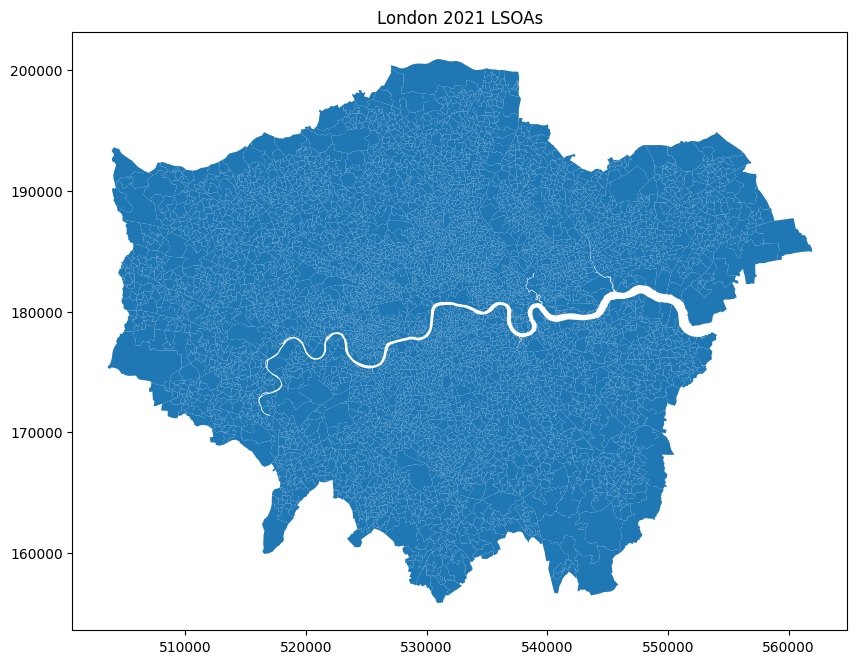

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
lsoas_london.plot(ax=ax)
ax.set_title("London 2021 LSOAs")
plt.show()

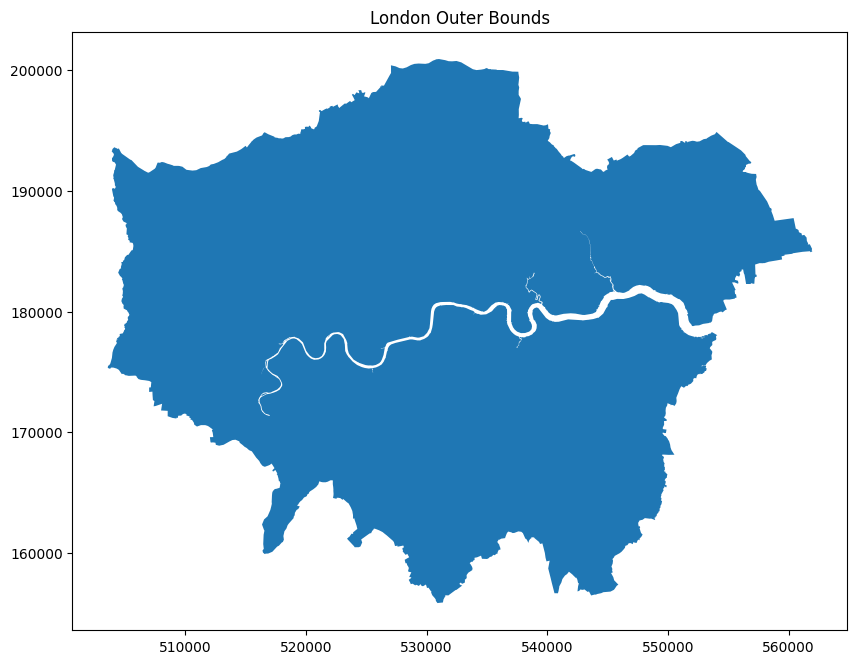

In [ ]:
all_london = lsoas_london.dissolve()
fig, ax = plt.subplots(figsize=(10, 10))
all_london.plot(ax=ax)
ax.set_title("London Outer Bounds")
plt.show()

Get the outline of the boroughs

In [ ]:
lsoas_london.head()

LSOA21CD                   LSOA21NM                              GlobalID  \
0  E01000001        City of London 001A  f1865556-4e62-48e3-a025-d93a40f15e46   
1  E01000002        City of London 001B  83e78aad-ee05-44a5-a8d3-077de6ed4053   
2  E01000003        City of London 001C  69c457df-229e-4446-9577-95ac1c9be694   
3  E01000005        City of London 001E  d537d59f-237a-45ed-a514-b0ab2a93e510   
4  E01000006  Barking and Dagenham 016A  8d0081fe-69e2-48ac-aaf9-fd270d60e339   

                                            geometry  \
0  POLYGON ((532105.312 182010.574, 532162.491 18...   
1  POLYGON ((532634.497 181926.016, 532619.141 18...   
2  POLYGON ((532135.138 182198.131, 532158.250 18...   
3  POLYGON ((533808.018 180767.774, 533649.037 18...   
4  POLYGON ((545122.049 184314.931, 545271.849 18...   

                       centroids  
0  POINT (532151.194 181615.201)  
1  POINT (532443.686 181645.725)  
2  POINT (532207.015 182030.130)  
3  POINT (533618.349 181157.354)  
4  POINT (544934.370 184297.547)

In [ ]:
# Function to extract the London borough from the LSOA name
def extract_borough(lsoa_name):
    for borough in london_boroughs:
        if borough in lsoa_name:
            return borough
    return None

# Create a new column 'London_Borough' with the matched borough name for each LSOA
lsoas_london['London_Borough'] = lsoas_london['LSOA21NM'].apply(extract_borough)

# Create a new GeoDataFrame for London boroughs by dissolving the geometries of LSOAs within each borough
london_borough_gdf = lsoas_london.dissolve(by='London_Borough')

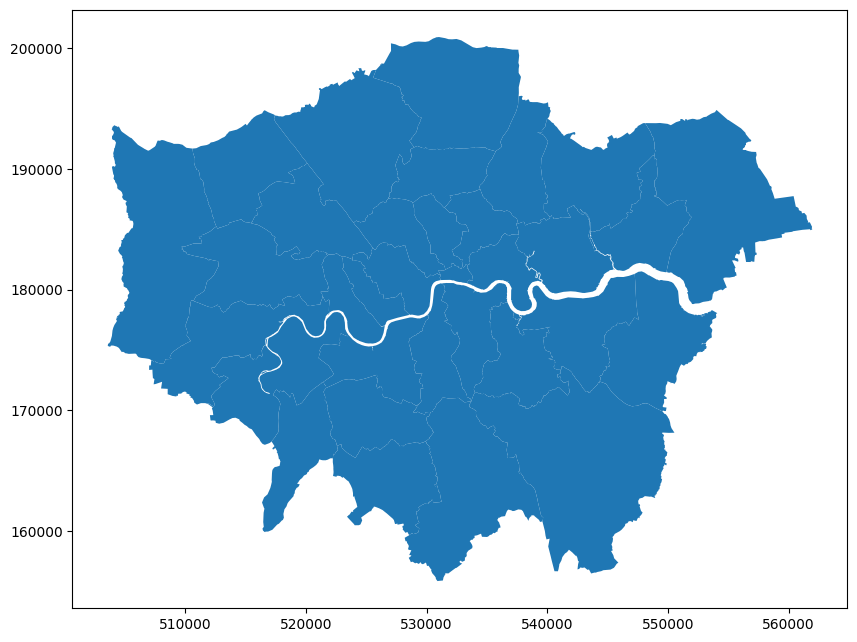

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
london_borough_gdf.plot(ax=ax)
plt.show()

In [ ]:
# lsoas_london_output = lsoas_london.drop(columns="centroids")
# lsoas_london_output.to_file("YOUR_PATH_HERE/Data/2021_lsoas")

## Reading in Access Data

In [ ]:
dep_access = pd.read_csv("YOUR_PATH_HERE/Data/r5r Data/access_all.csv")

In [ ]:
dep_access = dep_access[(dep_access["travel_time_p50"] != float('inf')) & (dep_access["travel_time_p50"] != "NaN")]
dep_access = gpd.GeoDataFrame(dep_access, geometry=gpd.points_from_xy(dep_access.lon, dep_access.lat), crs="EPSG:4326")
dep_access = dep_access.to_crs(crs="EPSG:27700")

In [ ]:
# Create new instances of old variables so nothing is overwritten...
dep_dict = copy.deepcopy(data_dict)
dep_new = copy.deepcopy(dep_access)

## Multivariate Analysis

In [ ]:
# Set 'LSOA21CD' and 'id' as index
dep_corr = dep_access.copy()
dep_corr.set_index(['LSOA21CD', 'id'], inplace=True)

# Pivot the DataFrame
df1 = dep_corr.pivot(columns='opportunity', values=['travel_time_p50', 'accessibility'])

# Flatten MultiIndex columns
df1.columns = ['_'.join(col).strip() for col in df1.columns.values]

# Reset index
df1.reset_index(inplace=True)
df2 = data_frames[6].copy()

# Pivot df2 to get each category as a separate column
pivot_df2 = df2.pivot(index='Lower layer Super Output Areas Code',
                      columns='Household deprivation (6 categories)',
                      values='Observation')

# Reset the index
pivot_df2.reset_index(inplace=True)

# Merge df1 and pivot_df2 on 'Lower layer Super Output Areas Code'
combined_df = pd.merge(df1, pivot_df2, left_on='LSOA21CD', right_on='Lower layer Super Output Areas Code')

In [ ]:
# Clean Dataframes
rename_dict = {}

for col in combined_df.columns:
    if "travel_time_p50_" in col:
        suffix = col.replace("travel_time_p50_", "")
        new_col_name = f"{suffix} Travel Times"
        rename_dict[col] = new_col_name
    elif "accessibility_" in col:
        suffix = col.replace("accessibility_", "")
        new_col_name = f"Accessible {suffix} Opportunities"
        rename_dict[col] = new_col_name

combined_df2 = combined_df.rename(columns=rename_dict)
combined_df2 = combined_df2.drop(columns=['id', 'LSOA21CD', 'Lower layer Super Output Areas Code', 'Does not apply'])

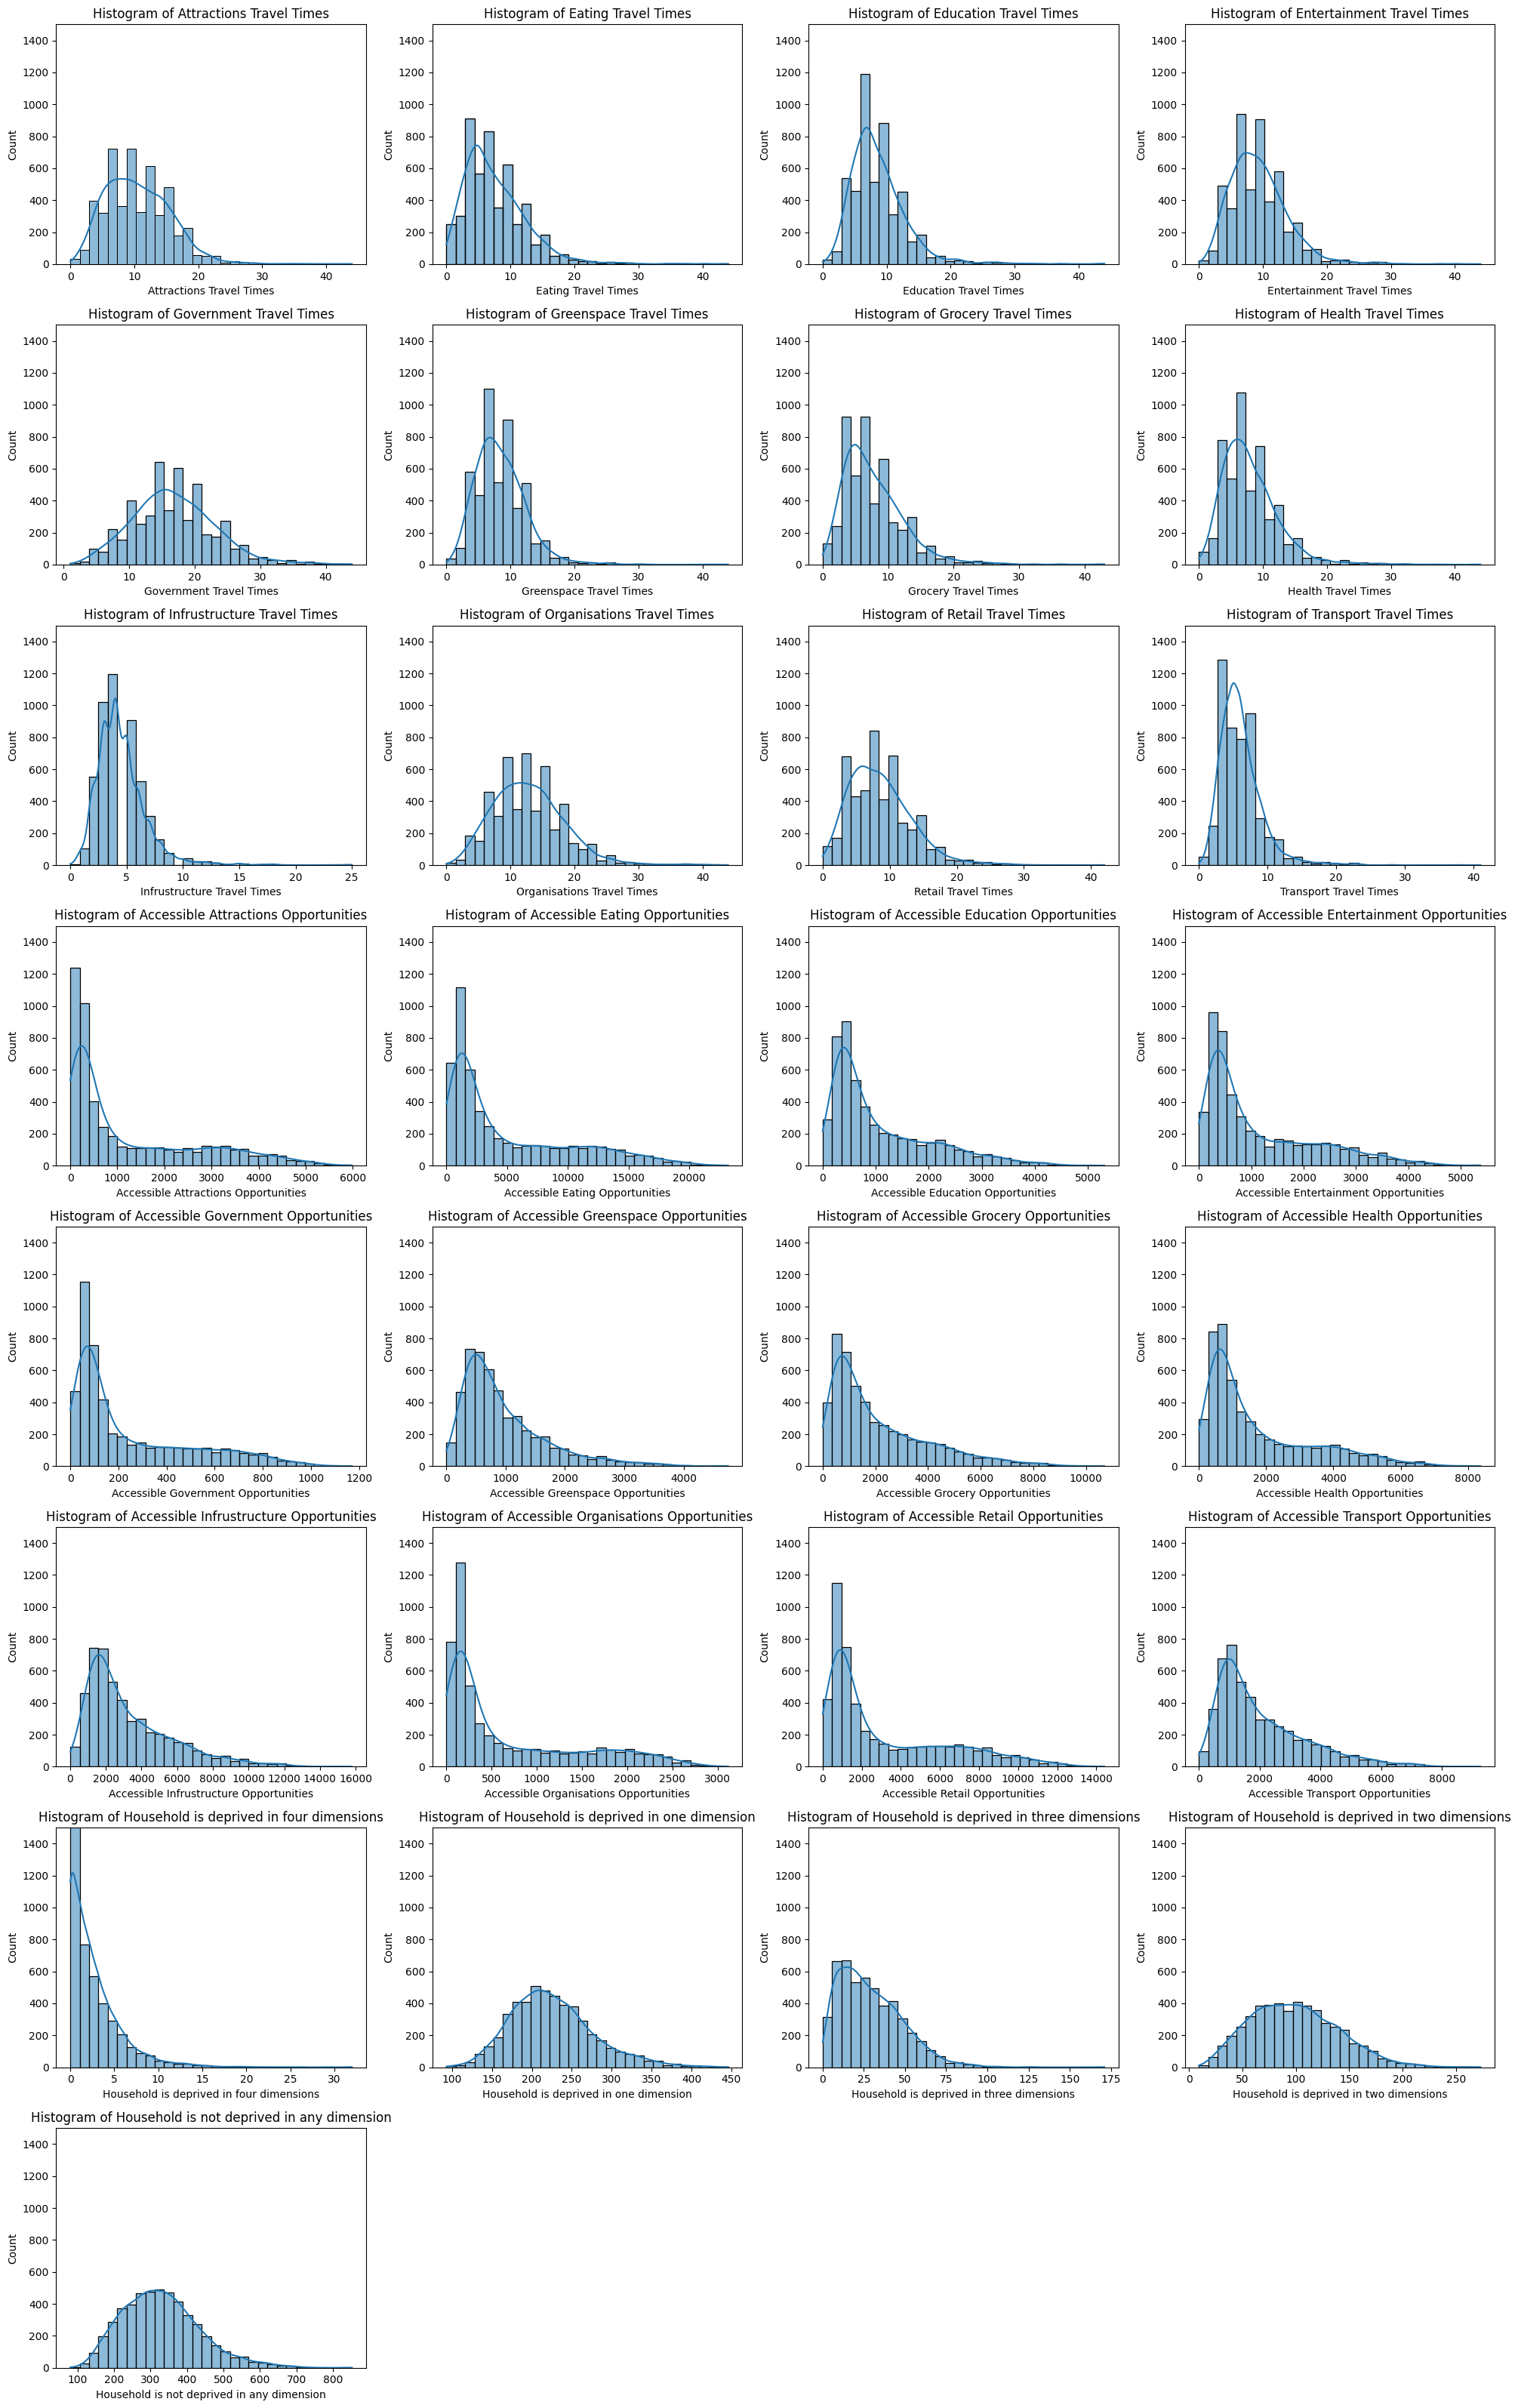

In [ ]:
# Set rows and columns for 5x6 grid
ncols = 4
nrows = 8

# Setting up the size of each plot; assume each subplot is 5x4
fig_width = 5 * ncols
fig_height = 4 * nrows

plt.figure(figsize=(fig_width, fig_height))

# Loop through the columns of combined_df2 and plot histograms
for index, col in enumerate(combined_df2.columns, start=1):
    if index > 30:
        break
    plt.subplot(nrows, ncols, index)
    sns.histplot(combined_df2[col], bins=30, kde=True)
    plt.ylim([0,1500])
    plt.title(f'Histogram of {col}')
    plt.tight_layout()

plt.show()

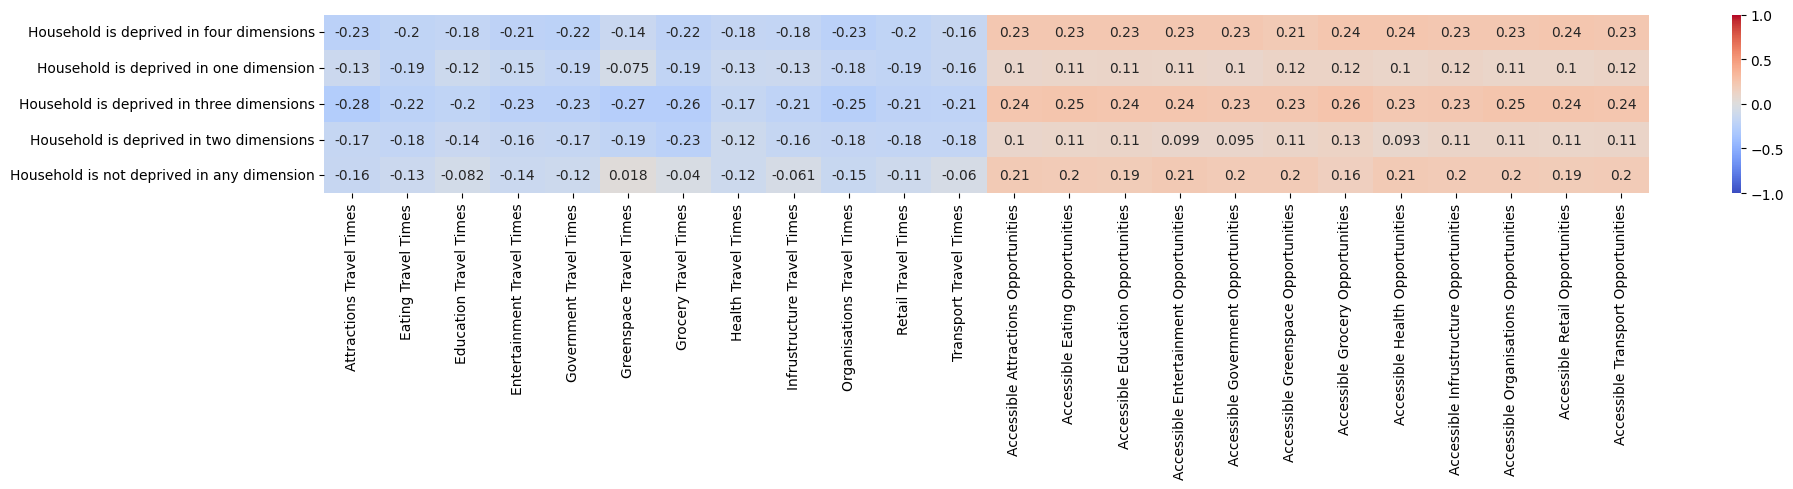

In [ ]:
# Calculate the correlation matrix
correlation_matrix = combined_df2.corr()

# Filter rows where index contains 'deprived'
filtered_rows = correlation_matrix[correlation_matrix.index.str.contains('deprived')]

# Filter out columns with the word 'deprived'
filtered_matrix = filtered_rows.loc[:, ~correlation_matrix.columns.str.contains('deprived')]

# Set up the matplotlib figure
plt.figure(figsize=(20, len(filtered_matrix)))

# Heatmap
sns.heatmap(filtered_matrix, annot=True, cmap='coolwarm', vmin=-1,vmax=1)

plt.tight_layout()
plt.show()

## Standardising Dep Access Data
Number of each type of point of interest, see data:


{'Attractions': 17549, 'Eating': 41991, 'Education': 17036, 'Entertainment': 18918, 'Government': 3089, 'Greenspace': 14140, 'Grocery': 23772, 'Health': 24264, 'Infrastructure': 79555, 'Organisations': 7241, 'Retail':36285, 'Transport': 32258}

In [ ]:
# Create an instance of StandardScaler & Transform the df so it is all z_score based
scaler = StandardScaler()

# Transform the travel time values using the scaler
dep_new['zscore_tt'] = scaler.fit_transform(dep_new[['travel_time_p50']])

opportunity_values = {
    'Attractions': 17549, 'Eating': 41991, 'Education': 17036,
    'Entertainment': 18918, 'Government': 3089, 'Greenspace': 14140,
    'Grocery': 23772, 'Health': 24264, 'Infrastructure': 79555,
    'Organisations': 7241, 'Retail': 36285, 'Transport': 32258} # THIS IS THE TOTAL NUMBER OF EACH POI TYPE USED

# Find the density and and then standardise it
dep_new['density'] = dep_new.apply(
    lambda row: row['accessibility'] / opportunity_values[row['opportunity']] if row['opportunity'] in opportunity_values else 0,
    axis=1)

dep_new['density_zscore'] = scaler.fit_transform(dep_new[['density']])

## Shannon's Entropy


In [ ]:
# Function to calculate Shannon's entropy
# It is based off the equation
def calculate_shannon_entropy(df):
    total_services = df['accessibility'].sum()
    df['pi'] = df['accessibility'] / total_services
    df['log_pi'] = np.log(df['pi'])
    df['product'] = df['pi'] * df['log_pi']
    entropy = -df['product'].sum()
    return entropy

# Group the data by LSOA and calculate the entropy for each group
entropy_scores = dep_new.groupby('LSOA21CD').apply(calculate_shannon_entropy).reset_index()
entropy_scores.columns = ['LSOA21CD', 'entropy']

# Scale the entropy scores using StandardScaler
scaler = StandardScaler()
entropy_scores['scaled_entropy'] = scaler.fit_transform(entropy_scores[['entropy']])

# Join back to dep_new so I can include it in the dictionary later
dep_final = dep_new.merge(entropy_scores, on='LSOA21CD')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = geta

## Building Vectors

In [ ]:
for i, row in dep_final.iterrows():
    # Get the LSOA21CD, opportunity, and entropy value
    lsoa_code = row['LSOA21CD']
    opportunity = row['opportunity']
    entropy = row['scaled_entropy']

    # If this LSOA isn't in the dictionary yet, warn and skip this row
    if lsoa_code not in dep_dict:
        print(f"Warning: LSOA code {lsoa_code} not found in census data.")
        continue

    # If the 'opportunities' key does not exist, create it
    if 'opportunities' not in dep_dict[lsoa_code]:
        dep_dict[lsoa_code]['opportunities'] = {}

    # If this opportunity isn't in the dictionary yet for this LSOA, add it
    if opportunity not in dep_dict[lsoa_code]['opportunities']:
        dep_dict[lsoa_code]['opportunities'][opportunity] = {
            'density_zscore': {'value': row['density_zscore']},
            'zscore_tt': {'value': row['zscore_tt']}
        }

    # Update the entropy score
    dep_dict[lsoa_code].update({'scaled_entropy': {'value': entropy}})

In [ ]:
# Make sure the dictionary is set up correctly
dep_dict = {k: v for k, v in dep_dict.items() if 'scaled_entropy' in v}

In [ ]:
dep_dict['E01000001']

{'census': {'cc1': 0.33511757918291935,
  'cc2': 0.5148833069530787,
  'cc3': 1.0690147858494519,
  'cc4': 0.8621261116339295,
  'cc5': 0.6241941921326716,
  'cc6': 0.9890778733707107,
  'cc7': 0.6669180290862992,
  'cc8': 0.7997285976031903,
  'cc9': 0.43038783430502026,
  'cc10': 0.7960181829586853,
  'cc11': 0.1834245249354884,
  'cc12': 4.380080869703645,
  'cc13': 0.7773257571239587,
  'cc14': 0.037251594121164334,
  'cc15': 1.124676624687228,
  'cc16': 0.15895812841380635,
  'cc17': 0.14238345637264205,
  'cc18': 0,
  'cc19': 1.6965687183600182,
  'cc20': 0.9480340461143324,
  'cc21': 0.11529188631750784,
  'cc22': 1.1393937383435233,
  'cc23': 0.5480724097926584,
  'cc24': 1.864542977749188,
  'cc25': 0,
  'cc26': 3.222434660690777,
  'cc27': 2.54781741362731,
  'cc28': 1.9609304892205812,
  'cc29': 1.4728203525794261,
  'cc30': 0.9389909008936826,
  'cc31': 0.6876834245255714,
  'cc32': 0.36350858403180497,
  'cc33': 0.5937886700869184,
  'cc34': 0.6735754670465389,
  'cc35': 0

The code below that builds the final set of vectors uses the values in cc dictionary created earlier. This should be double checked in case there was an issue loading in the dfs.

In [ ]:
# Create a new dictionary for the final vectors
final_vectors_dep = {}

for lsoa_code, lsoa_data in dep_dict.items():

    # Use the get method to fetch the value, or default to a 0-array if the key is missing
    # Some concentrations may be 0 and this is missing somehow, so this would just replace them with 0.
    # While this is not the case for all census categories, some LSOAs might not have populations
    # of peopl experiencing significant deprivation.
    nodep = np.array([lsoa_data['census'].get('cc43', 0)]) # corresponds to concentration people not deprived
    one = np.array([lsoa_data['census'].get('cc44', 0)]) # corresponds to concentration people deprived in 1 category
    two = np.array([lsoa_data['census'].get('cc45', 0)]) # corresponds to concentration people deprived in 2 categories
    three = np.array([lsoa_data['census'].get('cc46', 0)]) # corresponds to concentration people deprived in 3 categories
    four = np.array([lsoa_data['census'].get('cc47', 0)]) # corresponds to concentration people deprived in 4 categories

    # Get the entropy value
    entropy = np.array([lsoa_data['scaled_entropy']['value']])

    # Initialise a list to store density and tt values
    density_values = []
    tt_values = []

    # Iterate over each opportunity
    for opportunity, opportunity_data in lsoa_data['opportunities'].items():  # Change here
        # Get the density_zscore and zscore_tt values
        density = opportunity_data['density_zscore']['value']
        tt = opportunity_data['zscore_tt']['value']

        # Add these values to the respective lists
        density_values.append(density)
        tt_values.append(tt)

    # If there are no density and tt values, skip this LSOA code
    if not density_values or not tt_values:
        continue

    # Combine these into a dictionary of arrays
    vectors = {'nodep': nodep, 'one': one, 'two': two, 'three': three, 'four': four, 'entropy': entropy, 'density': np.array(density_values), 'tt': np.array(tt_values)}
    final_vectors_dep[lsoa_code] = vectors

In [ ]:
# Check to make sure it worked
final_vectors_dep['E01000001']

{'nodep': array([1.35410463]),
 'one': array([0.90227451]),
 'two': array([0.28435677]),
 'three': array([0.09554067]),
 'four': array([0]),
 'entropy': array([0.3902726]),
 'density': array([ 2.80905894,  5.06495511,  2.20485084,  1.97434967,  3.05097   ,
         3.68914062,  2.52795866, -0.91611325,  3.82419898,  3.28269372,
         1.84890456,  2.29576872]),
 'tt': array([-1.278084  , -1.278084  , -0.73789913, -1.09802238, -0.37777588,
        -0.5578375 , -0.73789913, -0.91796075, -1.09802238, -0.73789913,
        -1.09802238, -0.73789913])}

## Calculate the Scores

There are several ways in which the scores are calculated. First, the below code returns a dictionary with the final scores for all LSOAs. Then, it returns an unscaled version of that score, and finally it returns a dictionary containing the components that go into the final score. This last one is used later when decomposing the indicator.

In [ ]:
# New dictionary for final scores relating to deprivation
final_dep_scores = {}
final_dep_scores_all = {}
final_dep_scores_unscaled = {}

# Compute max z-score for each opportunity across all LSOAs
max_z_per_opportunity = {}
for _, lsoa_data in dep_dict.items():
    for opportunity, opportunity_data in lsoa_data.get('opportunities', {}).items():
        if 'zscore_tt' in opportunity_data:
            current_score = opportunity_data['zscore_tt']['value']
            if opportunity not in max_z_per_opportunity:
                max_z_per_opportunity[opportunity] = current_score
            else:
                max_z_per_opportunity[opportunity] = max(max_z_per_opportunity[opportunity], current_score)

for lsoa_code, vectors in final_vectors_dep.items():
    # Get the vectors
    two = vectors['two'][0]
    entropy = vectors['entropy'][0]
    density = vectors['density']
    tt = vectors['tt']

    tt_differences = []
    for opportunity, opportunity_data in dep_dict[lsoa_code].get('opportunities', {}).items():
        if 'zscore_tt' in opportunity_data:
            tt_differences.append(max_z_per_opportunity[opportunity] - opportunity_data['zscore_tt']['value'])

    # Now, instead of norm_tt, use the norm of tt_differences
    norm_density = np.linalg.norm(density)
    norm_tt_differences = np.linalg.norm(tt_differences)

    # Here, calculate the actual scores – scale by beta
    beta = 1/two
    final_score = (norm_density + norm_tt_differences + entropy)
    unscaled_score = norm_density + norm_tt_differences + entropy # Initialise unscaled_score here
    scaled_entropy = entropy # Initialise scaled_entropy here

    if lsoa_code in lsoas_london.index:
        area = lsoas_london.loc[lsoa_code, 'area']
        if area > 0: # Avoid division by 0 in case there is an error in the data somehow
            final_score = (final_score / area) * beta
            unscaled_score = unscaled_score / area
            scaled_density = (norm_density / area) * beta
            scaled_tt = (norm_tt_differences / area) * beta
            scaled_entropy = (entropy / area) * beta

    final_dep_scores[lsoa_code] = final_score
    final_dep_scores_unscaled[lsoa_code] = unscaled_score

    # Add it to the final score dictionary, the one where we can later decompose it into the scaled tt and density
    final_dep_scores_all[lsoa_code] = {
        'final_score': final_score,
        'scaled_density': norm_density,
        'scaled_tt': norm_tt_differences,
        'scaled_entropy': scaled_entropy}

Scale to be in a 0,1 range

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
unscaled_scores_list = []
final_scores_list = []

# Extract dictionary values to lists
final_scores_list = list(final_dep_scores.values())
unscaled_scores_list = list(final_dep_scores_unscaled.values())

# Convert the lists to numpy arrays, reshape them into 2D arrays and scale them
rescaled_final_scores = scaler.fit_transform(np.array(final_scores_list).reshape(-1, 1)).flatten()
rescaled_unscaled_scores = scaler.fit_transform(np.array(unscaled_scores_list).reshape(-1, 1)).flatten()

# Create new dictionaries with the LSOA codes and the corresponding scaled scores
final_dep_scores_scaled = dict(zip(final_dep_scores.keys(), rescaled_final_scores))
final_dep_scores_unscaled_scaled = dict(zip(final_dep_scores_unscaled.keys(), rescaled_unscaled_scores))

array([[<Axes: title={'center': 'Value'}>]], dtype=object)

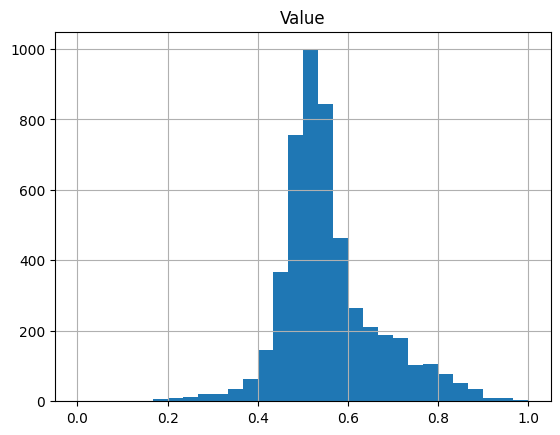

In [ ]:
df = pd.DataFrame(list(final_dep_scores_scaled.items()), columns=['Key', 'Value'])
df.hist(bins=30)

Basic plotting

In [ ]:
# Create a DataFrame from the scores dictionary
dep_df = pd.DataFrame.from_dict(final_dep_scores_scaled, orient='index', columns=['score'])
dep_df.reset_index(inplace=True)
dep_df.rename(columns={'index':'LSOA21CD'}, inplace=True)

<Axes: >

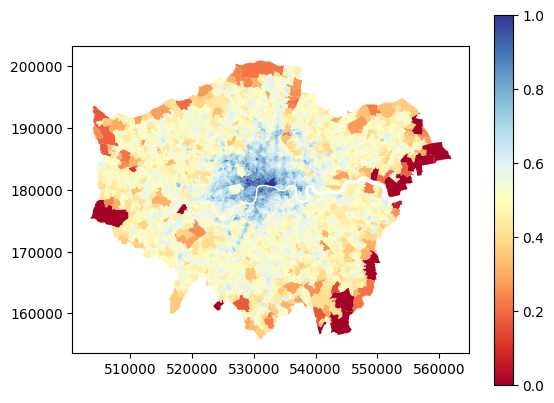

In [ ]:
dep_df['winsorised_score'] = winsorize(dep_df['score'], limits=[0.01, 0.01])

dep_lsoas = lsoas_london.copy()

#Add in scores of 0 for the LSOAs that had inf/NA values in r5r
dep_df['score'].fillna(0, inplace=True)

# Merge the lsoas_london shapefile with the standardised scores DataFrame based on the 'LSOA21CD' column
dep_merged = dep_lsoas.merge(dep_df, on='LSOA21CD',how='left')

# Fill in missing values with 0
dep_merged.fillna(0, inplace=True)

dep_merged.plot(column='score', cmap='RdYlBu', linewidth=0.01, edgecolor='0.8', legend=True)

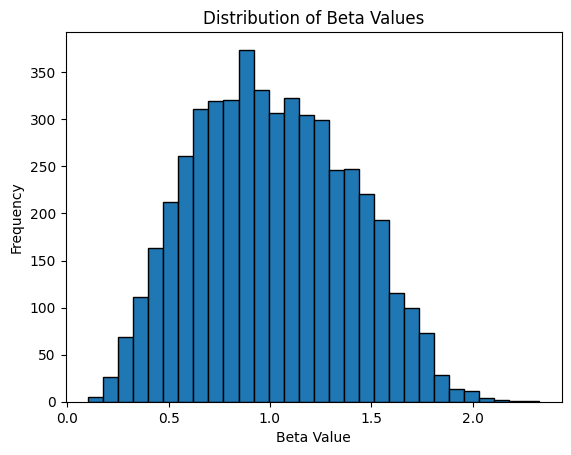

In [ ]:
# Extracting 'two' values
two_values = [v['two'][0] for v in final_vectors_dep.values()]

# Calculate beta values from 'two' values
beta_values = [1 / val for val in two_values]

plt.hist(two_values, bins=30, edgecolor='black')
plt.title("Distribution of Beta Values")
plt.xlabel("Beta Value")
plt.ylabel("Frequency")
plt.show()


## Building the Network and Community Detection

In [ ]:
# Get the point geometry for the graph
dep_points = dep_new.merge(dep_df, on='LSOA21CD')
columns_to_drop_networksetup = ['Unnamed: 0', 'V1', 'GlobalID', 'centroid_lat',
       'centroid_lon', 'lat', 'lon', 'id', 'travel_time_p50', 'opportunity',
       'percentile', 'cutoff', 'accessibility', 'zscore_tt', 'density',
       'density_zscore']
dep_points2 = dep_points.drop(columns = columns_to_drop_networksetup)

Clean the df to do delaunay triagnulation but buffer the edges based on the entire UK LSOA shapefile otherwise LSOAs that are not adjacent would have an edge and help make up a triangle.

In [ ]:
# Create a new dictionary for the final combined vectors
final_vectors_dep_combined = {}

for lsoa_code, vectors in final_vectors_dep.items():
    # Get the vectors
    nodep = np.array([vectors['nodep']])  # Converted to numpy array
    one = np.array([vectors['one']])  # Converted to numpy array
    two = np.array([vectors['two']])  # Converted to numpy array
    three = np.array([vectors['three']])  # Converted to numpy array
    four = np.array([vectors['four']])  # Converted to numpy array
    entropy = np.array([vectors['entropy']])  # Converted to numpy array
    density = vectors['density']
    tt = vectors['tt']

    # Flatten the 'two' and 'entropy' arrays
    nodep = nodep.flatten()
    one = one.flatten()
    two = two.flatten()
    three = three.flatten()
    four = four.flatten()
    entropy = entropy.flatten()

    # Combine the vectors into one array
    combined_vector = np.concatenate((nodep, one, two, three, four, entropy, density, tt))

    final_vectors_dep_combined[lsoa_code] = combined_vector

In [ ]:
final_vectors_dep_combined['E01000003']

array([ 0.99157072,  1.13724018,  0.75116305,  0.70852283,  1.70268144,
        0.37348268,  2.56323178,  4.60755301,  1.88115724,  1.7231775 ,
        2.85261584,  3.1867971 ,  2.23781763, -0.91611325,  3.52890084,
        2.98184355,  1.55430011,  1.92435065, -1.278084  , -1.278084  ,
       -1.09802238, -1.09802238, -0.01765263, -1.09802238, -0.91796075,
       -1.45814563, -0.5578375 , -0.91796075, -0.91796075, -1.09802238])

In [ ]:
# Convert the final_vectors dictionary to a DataFrame
vectors_df = pd.DataFrame.from_dict(final_vectors_dep_combined, orient='index')
vectors_df = vectors_df.reset_index() # Resets the index and brings the LSOA codes back as a column
vectors_df.columns = ['LSOA21CD', 'vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6', 'vec7', 'vec8', 'vec9', 'vec10',
                      'vec11', 'vec12', 'vec13', 'vec14', 'vec15', 'vec16', 'vec17', 'vec18', 'vec19', 'vec20',
                      'vec21', 'vec22', 'vec23', 'vec24', 'vec25', 'vec26', 'vec27', 'vec28', 'vec29', 'vec30']  # Naming the columns

# Merge the vectors DataFrame with the DataFrame that contains the geometries
merged_vectors_df = pd.merge(vectors_df, dep_points2, right_on='LSOA21CD', left_on='LSOA21CD')

# Merge vectors_df on 'LSOA21CD', this will ensure all LSOAs are included and then I can buffer
merged_df = pd.merge(lsoas2021, vectors_df, how='left', on='LSOA21CD')

# Clean the df
merged_df = merged_df.drop(columns={"geometry"})
merged_df = merged_df.fillna(0) # the LSOAs not in London receieve NaN values so those need to be filled

Create the Delaunay Triangulation

In [ ]:
# Initialise a new graph
G_full = nx.Graph()

# Add nodes to the graph, using the vectors and geometries as attributes
for index, row in merged_df.iterrows():
    attributes = [row[f'vec{i+1}'] for i in range(26)]  # Get all the vectors from 'vec1' to 'vec26'
    G_full.add_node(row['LSOA21CD'], attributes=attributes, point=row['centroids'])

# Create a Delaunay Triangulation for the full set of LSOAs
points = [row.centroids for _, row in merged_df.iterrows()]
tri = Delaunay([(point.x, point.y) for point in points])

Add the edges and calculate the cosing similarity & remove the nodes without London LSOAs

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

In [ ]:
# Add edges to the graph
for simplex in tri.simplices:
    lsoa_code_1 = merged_df.iloc[simplex[0]]['LSOA21CD']
    lsoa_code_2 = merged_df.iloc[simplex[1]]['LSOA21CD']
    lsoa_code_3 = merged_df.iloc[simplex[2]]['LSOA21CD']

    # Compute cosine similarity between each pair of nodes, and use it as the edge weight
    vec1 = np.array(G_full.nodes[lsoa_code_1]['attributes']).reshape(1, -1)
    vec2 = np.array(G_full.nodes[lsoa_code_2]['attributes']).reshape(1, -1)
    vec3 = np.array(G_full.nodes[lsoa_code_3]['attributes']).reshape(1, -1)

    # Compute the cosine similarities and add 1 to make positive
    cos_sim_1_2 = cosine_similarity(vec1, vec2)[0][0] + 1
    cos_sim_2_3 = cosine_similarity(vec2, vec3)[0][0] + 1
    cos_sim_3_1 = cosine_similarity(vec3, vec1)[0][0] + 1

    G_full.add_edge(lsoa_code_1, lsoa_code_2, weight=cos_sim_1_2)
    G_full.add_edge(lsoa_code_2, lsoa_code_3, weight=cos_sim_2_3)
    G_full.add_edge(lsoa_code_3, lsoa_code_1, weight=cos_sim_3_1)

# Create a copy of the full graph, remove nodes associated with LSOAs not in London
G_new = G_full.copy()

non_london_LSOA_codes = set(lsoas2021['LSOA21CD']) - set(lsoas_london['LSOA21CD'])
G_new.remove_nodes_from(non_london_LSOA_codes)

# Print the number of nodes and edges in the graph
print(f"Full graph has {G_full.number_of_nodes()} nodes and {G_full.number_of_edges()} edges")
print(f"New graph has {G_new.number_of_nodes()} nodes and {G_new.number_of_edges()} edges")

Full graph has 35672 nodes and 106997 edges
New graph has 4994 nodes and 14819 edges


In [ ]:
# Check to see if it worked - print the weights of the first few edges and the node attributes
for edge in list(G_new.edges(data=True))[:4]:
  print(edge)
for node in list(G_new.nodes(data=True))[:4]:
  print(node)

('E01000001', 'E01032740', {'weight': 1.996987983025179})
('E01000001', 'E01003935', {'weight': 1.9692392031994772})
('E01000001', 'E01032739', {'weight': 1.995338458200079})
('E01000001', 'E01002724', {'weight': 1.9919421673533233})
('E01000001', {'attributes': [1.3541046343303589, 0.9022745083065848, 0.2843567679629323, 0.09554066812082407, 0.0, 0.3902725979428456, 2.8090589382806397, 5.06495510547396, 2.204850837660639, 1.9743496742372868, 3.050970000490399, 3.6891406165863505, 2.5279586607449978, -0.9161132528457209, 3.824198980698133, 3.2826937243968417, 1.8489045617333477, 2.295768718679894, -1.278084004453319, -1.278084004453319, -0.7378991290595249, -1.0980223793220543, -0.37777587879699553, -0.5578375039282603, -0.7378991290595249, -0.9179607541907896], 'point': <POINT (532151.194 181615.201)>})
('E01000002', {'attributes': [1.3620334058852839, 0.9176044150011141, 0.23815488304833818, 0.03238797729985864, 0.0, 0.3308293000006496, 2.5817578807119115, 4.659070307246939, 1.862807

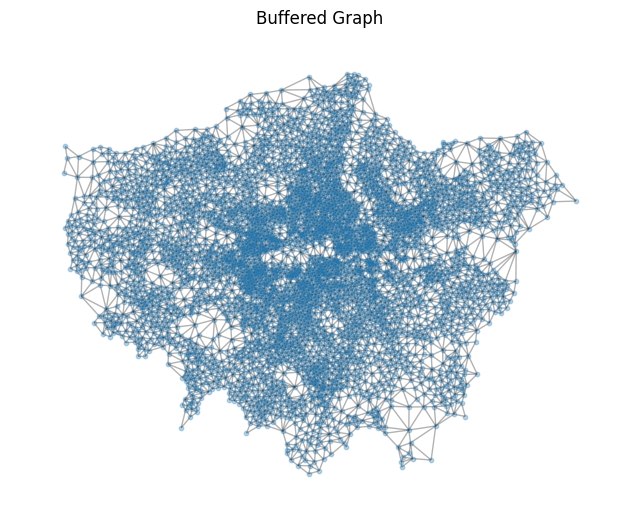

In [ ]:
# Create a mapping for the coordinates of each LSOA
LSOA_to_centroids = {node: (G_new.nodes[node]['point'].x, G_new.nodes[node]['point'].y) for node in G_new.nodes}

# Draw the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(G_new, pos=LSOA_to_centroids, with_labels=False, node_size=10, alpha=0.3, ax=ax)
ax.set_aspect('equal')  # ensures an equal aspect ratio
plt.title("Buffered Graph")
plt.show()

## Random Walk
https://igraph.org/r/doc/random_walk.html

<Axes: >

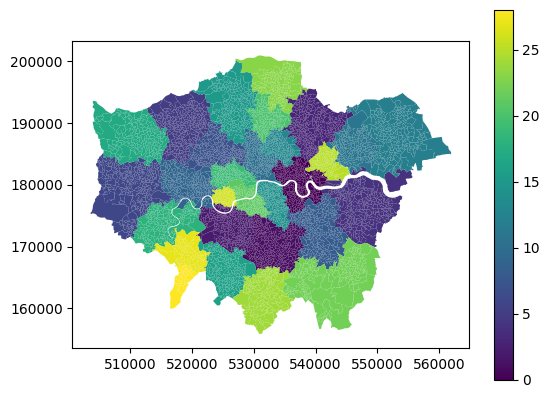

In [ ]:
# Convert the graph to igraph because walktrap takes weights in igraph
G_ig = ig.Graph.from_networkx(G_new)

# Store a mapping of indices to node names
index_to_node = {index: node for index, node in enumerate(G_new.nodes)}

# Compute the communities
walktrap_comm = G_ig.community_walktrap(weights="weight", steps=50)
communities = walktrap_comm.as_clustering()

# Convert communities to list of lists (of nodes), mapping indices back to node names
communities = [[index_to_node[index] for index in community] for community in communities]

# Create NodeClustering object
partitions = NodeClustering(communities, G_new, "Walktrap")

# Assign the community id to each node
for i, community in enumerate(partitions.communities):
    for node in community:
        G_new.nodes[node]["community"] = i

# Create a DataFrame from the graph
graph_df = pd.DataFrame.from_records([{"LSOA21CD": node, **data} for node, data in G_new.nodes(data=True)])

# Merge the DataFrame with the GeoDataFrame
dep_merged_communities = dep_merged.merge(graph_df, on='LSOA21CD')

# Plot the choropleth map
dep_merged_communities.plot(column='community', cmap='viridis', legend=True)


## Modularity
https://igraph.org/python/doc/api/igraph.Graph.html

In [ ]:
# Create a reverse mapping from node names to indices
node_to_index = {node: index for index, node in index_to_node.items()}

# Create a membership list from the communities
membership = [0] * len(G_ig.vs)
for community_id, community in enumerate(communities):
    for node in community:
        # Use the reverse mapping to get the index of the node
        index = node_to_index[node]
        membership[index] = community_id

# Compute modularity using the membership list
modularity_score = G_ig.modularity(membership, weights="weight")

print(f"Modularity Score: {modularity_score}")

Modularity Score: 0.8843652439203027


In [ ]:
num_comm_dep = dep_merged_communities['community'].unique()
np.sort(num_comm_dep)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

## Mapping

Merge back and find the median score per community

In [ ]:
# Merge 'score' back to the GeoDataFrame so we can work with communities
dep_merged_communities['score'].fillna(0, inplace=True) # to account for r5r error
dep_community_scores = dep_merged_communities.groupby('community')['score'].median()
dep_community_scores_df = dep_community_scores.reset_index()
dep_comm_and_score = dep_merged_communities.merge(dep_community_scores_df, how='left', on='community', suffixes=('', '_median'))
dep_comm_dissolved = dep_comm_and_score.dissolve(by='community')

In [ ]:
# To get the communities back
dep_comm_dissolved = dep_comm_dissolved.reset_index()

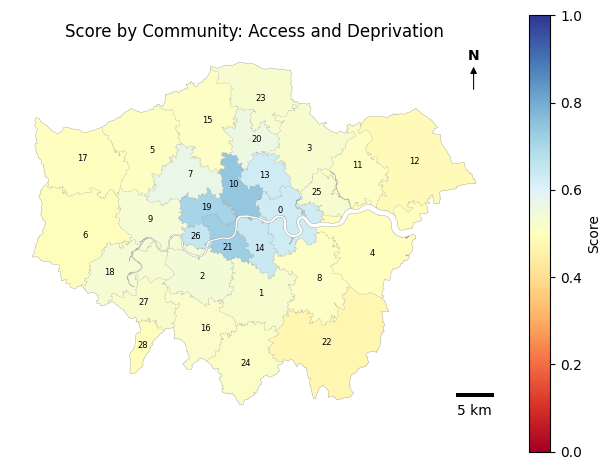

In [ ]:
# Create the figure and axis
fig, ax = plt.subplots()

# First plot the all_london to lay the base
all_london.boundary.plot(ax=ax, color='grey', linewidth=0.25, alpha=0.5)
ax.axis('off')

# Then the actual map
dep_comm_dissolved.plot(column='score_median', cmap='RdYlBu', edgecolor='grey', linewidth=0.1, legend=False, ax=ax, vmin=0, vmax=1)
ax.set_title("Score by Community: Access and Deprivation")
ax.axis('off')

# Create and customise the legend manually
norm = plt.Normalize(vmin=0, vmax=1)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='RdYlBu'), ax=ax, orientation='vertical')
cbar.set_label("Score")

# Add labels for each polygon based on the community value
for x, y, label in zip(dep_comm_dissolved.geometry.representative_point().x, dep_comm_dissolved.geometry.representative_point().y, dep_comm_dissolved['community']):
    ax.text(x, y, label, fontsize=6, ha='center', va='center')

# Add scale bar
scalebar = ScaleBar(1, units='m', location='lower right', scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# Enhanced North arrow with patch
arrow_x = 0.95  # position to upper right
arrow_y = 0.95  # position to upper right
arrow_length = 0.075  # Reduced size for a smaller arrow

ax.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y-arrow_length),
            xycoords=ax.transAxes,
            arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='-|>', lw=0.75),
            ha='center', va='center')

# Labeling the North arrow
ax.text(arrow_x, arrow_y+0.02, 'N', ha='center', va='center', fontweight='bold', fontsize=10, transform=ax.transAxes)

# Show the map
plt.tight_layout()
plt.show()

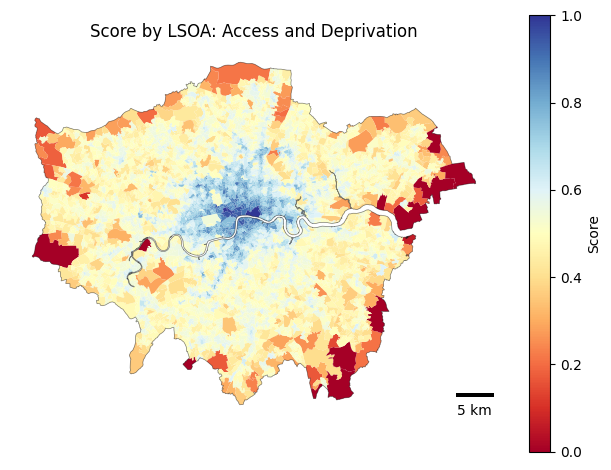

In [ ]:
# Create the figure and axis
fig, ax = plt.subplots()

# First plot the all_london to lay the base
all_london.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.5)
ax.axis('off')

# Plot the data
dep_merged.plot(column='score', cmap='RdYlBu',  edgecolor='black', linewidth=0, legend=False, ax=ax, vmin=0, vmax=1)
ax.set_title("Score by LSOA: Access and Deprivation")
ax.axis('off')

# Create and customise the legend manually
norm = plt.Normalize(vmin=0, vmax=1)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='RdYlBu'), ax=ax, orientation='vertical')
cbar.set_label("Score")

# Add scale bar
scalebar = ScaleBar(1, units='m', location='lower right', scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# Show the map
plt.tight_layout()
plt.show()

In [ ]:
dep_merged.score.median()

0.5350351102345441

## Case Study Communities

In [ ]:
dep_comm_dissolved.score_median.sort_values()

22   0.47
12   0.48
28   0.49
6    0.49
4    0.50
17   0.50
5    0.50
8    0.51
15   0.51
11   0.51
24   0.51
16   0.52
27   0.52
3    0.52
1    0.53
23   0.53
25   0.53
18   0.53
9    0.53
2    0.54
20   0.56
7    0.57
0    0.63
13   0.63
14   0.64
26   0.65
19   0.71
21   0.72
10   0.74
Name: score_median, dtype: float64

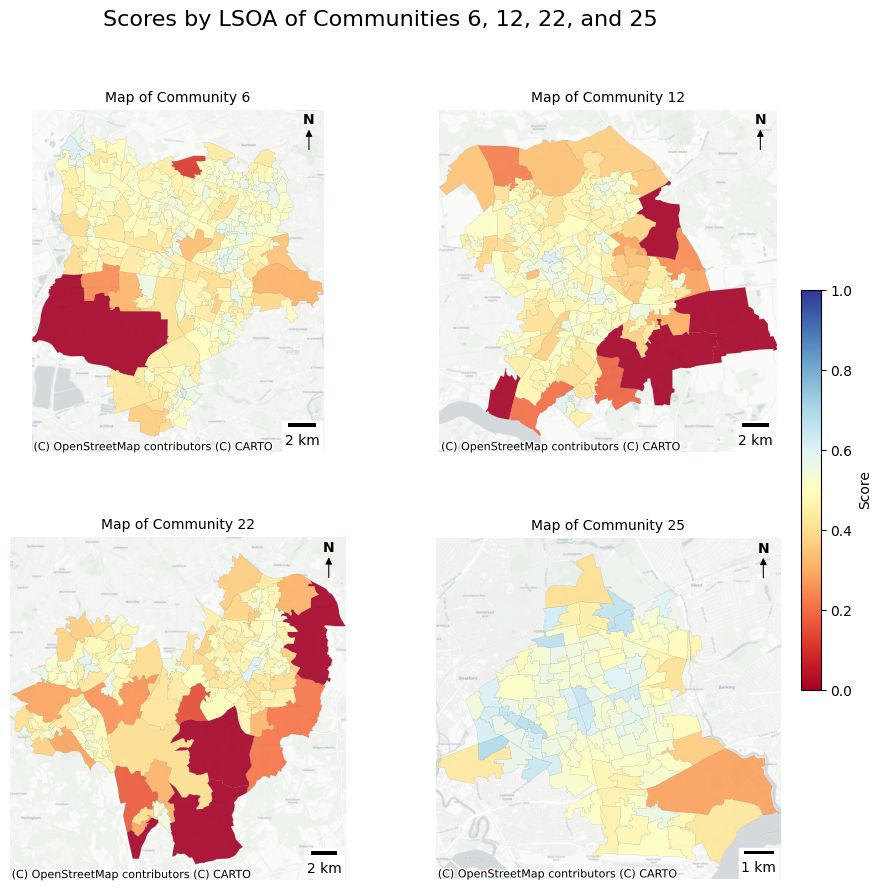

In [ ]:
# Filter only a few communities
selected_communities = dep_comm_and_score[dep_comm_and_score['community'].isin([6, 12, 22, 25])]

# Convert to Web Mercator (EPSG:3857) so they're the same
if selected_communities.crs != "EPSG:3857":
    selected_communities = selected_communities.to_crs(epsg=3857)

# Create the figure and axes in a 2x2 grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Common color scale for both plots
vmin, vmax = 0, 1

for ax, community in zip(axs.ravel(), [6, 12, 22, 25]):
    subset = selected_communities[selected_communities['community'] == community]
    buffer = 0.05 * (subset.total_bounds[3] - subset.total_bounds[1])

    # Set the axis limits
    ax.set_xlim(subset.total_bounds[0], subset.total_bounds[2])
    ax.set_ylim(subset.total_bounds[1] - buffer, subset.total_bounds[3] + buffer)

    # Add the basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    subset.plot(column='score', cmap='RdYlBu', linewidth=0.05, edgecolor='0.1', legend=False, ax=ax, alpha=0.9, vmin=vmin, vmax=vmax)

    # Plot the subset data
    ax.set_axis_off()
    ax.set_title(f"Map of Community {community}", fontsize=10)

    # Scale bar
    scalebar = ScaleBar(1, units='m', location='lower right', scale_loc='bottom', length_fraction=0.1)
    ax.add_artist(scalebar)

    # North arrow
    arrow_x = 0.95
    arrow_y = 0.95
    arrow_length = 0.075

    ax.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y - arrow_length),
                xycoords=ax.transAxes,
                arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='-|>', lw=0.75),
                ha='center', va='center')

    # Labeling the North arrow
    ax.text(arrow_x, arrow_y + 0.02, 'N', ha='center', va='center', fontweight='bold', fontsize=10, transform=ax.transAxes)

# Adjust spacing between plots
plt.subplots_adjust(wspace=0.25, hspace=0.25)

# Create and customise the legend manually
cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
norm = plt.Normalize(vmin=0, vmax=1)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='RdYlBu'), cax=cax, orientation='vertical')
cbar.set_label("Score")

fig.suptitle('Scores by LSOA of Communities 6, 12, 22, and 25', fontsize=16)
plt.show()

## Plot the concentration of older people

<Axes: >

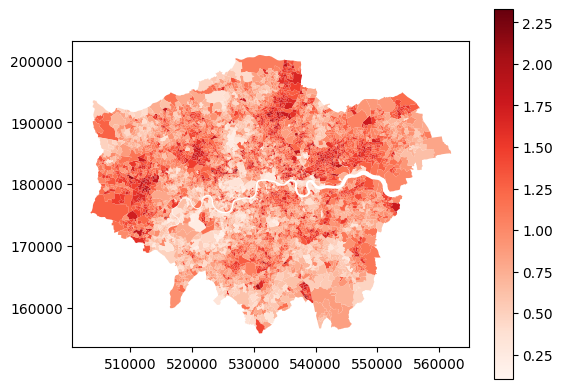

In [ ]:
dep_pop_two = data_frames[6][data_frames[6]['Household deprivation (6 categories) Code'] == 3]

# Create a list of tuples containing LSOA codes and their corresponding 'cc45' values
lsoa_cc45_values = [(lsoa_code, data['census'].get('cc45', np.nan)) for lsoa_code, data in data_dict.items()]

# Convert the list of tuples to a DataFrame
cc45_df = pd.DataFrame(lsoa_cc45_values, columns=['LSOA', 'cc45_value'])

dep_pop_gdf = dep_pop_two.merge(cc45_df, left_on='Lower layer Super Output Areas Code', right_on ="LSOA")

# Plot the concentrations per LSOA
lsoa_dep_pop = lsoas_london.copy()
dep_pop_gdf2 = lsoa_dep_pop.merge(dep_pop_gdf, left_on='LSOA21CD', right_on ="Lower layer Super Output Areas Code")
dep_pop_gdf2.plot(column='cc45_value', cmap='Reds', linewidth=0.01, legend=True)

In [ ]:
dep_pop_gdf2.cc45_value.mean()

1.0123700393305002

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


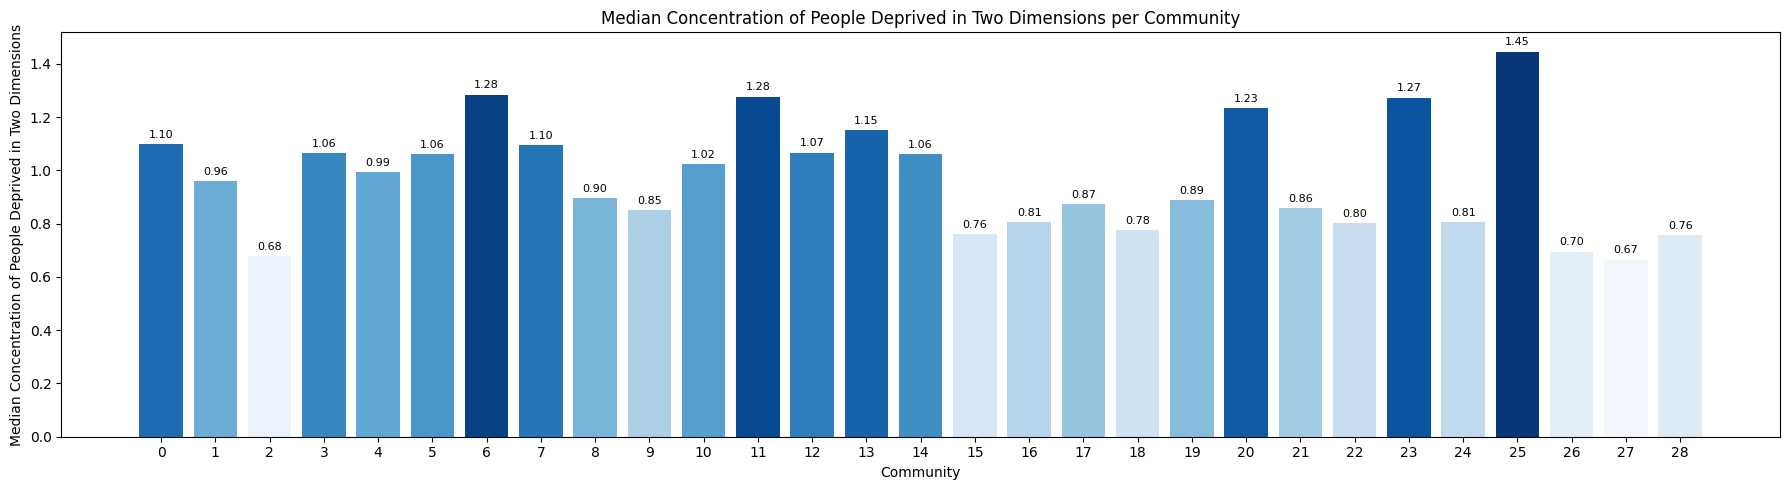

In [ ]:
# Ensure the dataframes are in the same projection
if dep_pop_gdf2.crs != "EPSG:3857":
    dep_pop_gdf = dep_pop_gdf2.to_crs(epsg=3857)

if dep_comm_dissolved.crs != "EPSG:3857":
    dep_comm_dissolved = dep_comm_dissolved.to_crs(epsg=3857)

# Perform a spatial join
intersected_lsoas = gpd.sjoin(dep_pop_gdf, dep_comm_dissolved, how="inner", op='intersects')

#  Group by community and calculate the median percentage of deprived individuals
community_median_dep = intersected_lsoas.groupby('community')['cc45_value'].median()

# Plot the results as a vertical bar chart
fig, ax = plt.subplots(figsize=(18, 5))

communities = community_median_dep.index.tolist()
median_dep = community_median_dep.values.tolist()

# Define a continuous blue color palette using seaborn
blue_palette = sns.color_palette("Blues", len(median_dep))
sorted_median_dep, sorted_communities = zip(*sorted(zip(median_dep, communities)))

bars = ax.bar(sorted_communities, sorted_median_dep, color=blue_palette)

# Annotate the bars with the actual numbers
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=8)

ax.set_ylabel('Median Concentration of People Deprived in Two Dimensions')
ax.set_xticks(communities)
ax.set_xlabel('Community')
ax.set_title('Median Concentration of People Deprived in Two Dimensions per Community')
plt.tight_layout()
plt.xticks()
plt.show()

In [ ]:
community_median_dep.mean()

0.9726699948085528

## Unscaled Data

In [ ]:
# Create a DataFrame from the scores dictionary
unscaled_dep = pd.DataFrame.from_dict(final_dep_scores_unscaled_scaled, orient='index', columns=['score'])
unscaled_dep.reset_index(inplace=True)
unscaled_dep.rename(columns={'index':'LSOA21CD'}, inplace=True)
lsoas_unscaled_dep = lsoas_london.copy()
# Merge the lsoas_london shapefile with the standardised scores DataFrame based on the 'LSOA21CD' column
unscaled_dep_final = lsoas_unscaled_dep.merge(unscaled_dep, on='LSOA21CD')

In [ ]:
unscaled_dep_final['winsorised_score'] = winsorize(unscaled_dep_final['score'], limits=[0.00, 0.15])

In [ ]:
un = unscaled_dep.merge(dep_merged_communities, on='LSOA21CD')
un = un.rename(columns={'score_x':'unscaled_score'})
un['unscaled_score'].fillna(0, inplace=True)

# Group by 'community' and aggregate 'unscaled_score' using the median
un = un.groupby('community')['unscaled_score'].median()
un = un.reset_index()

# Merge this median score back into dep_merged_communities
un_f = un.merge(dep_merged_communities, how='left', on='community', suffixes=('', '_median'))
un_f = un_f.drop(columns=['centroids', 'point'])

# Ensure 'geometry' is the active geometry
un_f = un_f.set_geometry('geometry')
dissolved_unscaled_dep_final = un_f.dissolve(by='community')

In [ ]:
dissolved_unscaled_dep_final = dissolved_unscaled_dep_final.reset_index()

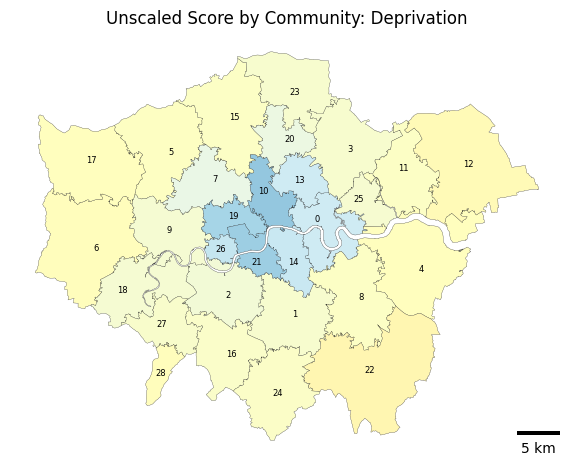

In [ ]:
# Create the figure and axis
fig, ax = plt.subplots()

# First plot the all_london to lay the base
all_london.boundary.plot(ax=ax, color='grey', linewidth=0.1, alpha=0.75)
ax.axis('off')

# Plot the data
dissolved_unscaled_dep_final.plot(column='unscaled_score', cmap='RdYlBu',  edgecolor='black', linewidth=0.15, legend=False, ax=ax, vmin=0, vmax=1)
ax.set_title("Unscaled Score by Community: Deprivation")
ax.axis('off')

# Add labels for each polygon based on the community value
for x, y, label in zip(dissolved_unscaled_dep_final.geometry.representative_point().x, dissolved_unscaled_dep_final.geometry.representative_point().y, dissolved_unscaled_dep_final['community']):
    ax.text(x, y, label, fontsize=6, ha='center', va='center')

# Add scale bar
scalebar = ScaleBar(1, units='m', location='lower right', scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# Show the map
plt.tight_layout()
plt.show()

## Decomposed Scores

<ipython-input-63-986cdff33bc2>:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dep_allscores_grouped = dep_allscores.groupby('community').median()


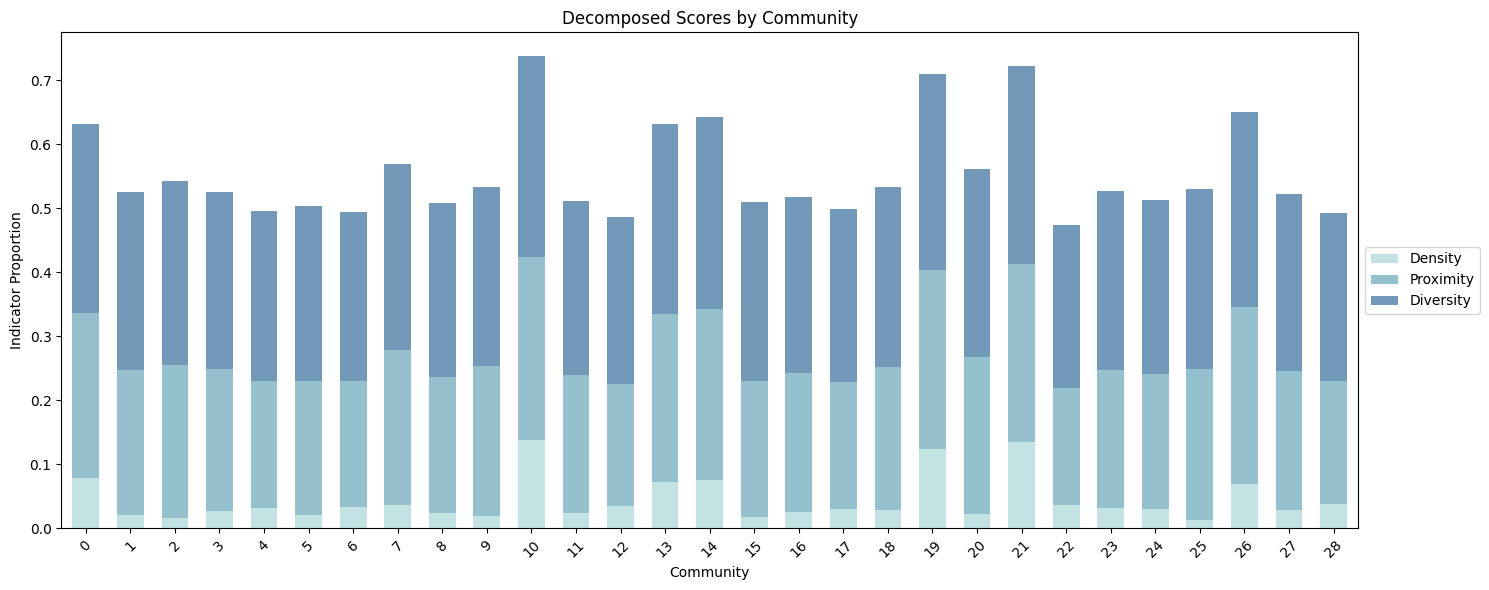

In [ ]:
# Convert the dictionary to a DataFrame
final_dep_scores_all_df = pd.DataFrame.from_dict(final_dep_scores_all, orient='index')

# Scale each score column individually using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
for col in final_dep_scores_all_df.columns:
    final_dep_scores_all_df[col] = scaler.fit_transform(final_dep_scores_all_df[[col]])

# Merging the DataFrame with graph_df to get the 'community' information
final_dep_scores_all_df.reset_index(inplace=True)
final_dep_scores_all_df.rename(columns={'index':'LSOA21CD'}, inplace=True)
dep_allscores = final_dep_scores_all_df.merge(graph_df, on='LSOA21CD')
dep_allscores = dep_allscores.rename(columns={'scaled_density': 'Density', 'scaled_tt':'Travel Time', 'scaled_entropy':'Diversity'})

# Group by community and compute the median values
dep_allscores_grouped = dep_allscores.groupby('community').median()

# Compute the proportions based on their relative contributions and scale them to match the height of final_score
total_score = dep_allscores_grouped['Density'] + dep_allscores_grouped['Travel Time'] + dep_allscores_grouped['Diversity']

dep_allscores_grouped['Density (%)'] = (dep_allscores_grouped['Density'] / total_score) * dep_allscores_grouped['final_score']
dep_allscores_grouped['Travel Time (%)'] = (dep_allscores_grouped['Travel Time'] / total_score) * dep_allscores_grouped['final_score']
dep_allscores_grouped['Diversity (%)'] = (dep_allscores_grouped['Diversity'] / total_score) * dep_allscores_grouped['final_score']

# Plotting the stacked bar chart using the computed values
fig, ax = plt.subplots(figsize=(15, 6))
dep_allscores_grouped[['Density (%)', 'Travel Time (%)', 'Diversity (%)']].plot(kind='bar', stacked=True,
                                                                               ax=ax, color=sns.color_palette("ch:start=.2,rot=-.3"),
                                                                               width=0.6, legend=None)
# Customising the legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ['Density', 'Proximity', 'Diversity']
ax.legend(handles, new_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Decomposed Scores by Community')
plt.ylabel('Indicator Proportion')
plt.xlabel('Community')
plt.xticks(rotation=45)

# Adjust the layout
plt.tight_layout()
plt.show()

## Sensitivity Testing with Time Series Data

In [ ]:
dd_sens = copy.deepcopy(data_dict)

In [ ]:
# This currently still has all the LSOAs in England, so we need to subset it
lsoas_london_list = lsoas_london.LSOA21CD.tolist()
dd_sens = {lsoa: data for lsoa, data in data_dict.items() if lsoa in lsoas_london_list}

In [ ]:
folder_path = "YOUR_PATH_HERE/Data/r5r Data/Dep_sensitivity"

# NOTE: this is predicated upon renaming the files that are being read in, just as they are in the google drive 'data' folder
def get_integer_from_filename(filename):
    return int(''.join(filter(str.isdigit, filename)))

# List all subfolders
subfolders = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]

time_point_dataframes = {}

for subfolder in subfolders:
    current_subfolder_path = os.path.join(folder_path, subfolder)
    csv_files = [file for file in os.listdir(current_subfolder_path) if file.endswith('.csv')]

    for csv_file in csv_files:
        time_point = get_integer_from_filename(csv_file)

        df = pd.read_csv(os.path.join(current_subfolder_path, csv_file))
        df['opportunity'] = subfolder

        if time_point not in time_point_dataframes:
            time_point_dataframes[time_point] = []
        time_point_dataframes[time_point].append(df)

# Consolidate dataframes based on the time_point
for time_point, dfs in time_point_dataframes.items():
    time_point_dataframes[time_point] = pd.concat(dfs, ignore_index=True)

In [ ]:
# Just to be sure all of the dfs have all the 'opportunities'
opp_unique = time_point_dataframes[700].opportunity.unique()
print(len(opp_unique))

12


### Calculate Scores for all dfs

The below code captures much of what was done above but it does it for all of the dfs involved in sensitivity testing. It builds upon the same initial census vector.

In [ ]:
scaled_scores_per_timepoint = {}
final_vectors_dep_sens = {}
final_scores_dict_sens_dep = {}

# Define a dictionary to store the max z-scores for each time point
max_z_per_timepoint = {}

for time_point, df in time_point_dataframes.items():
    # Remove null rows
    df = df[(df["travel_time_p50"] != float('inf')) & (df["travel_time_p50"] != "NaN")]

    # Calculate Shannon's entropy
    total_services = df['accessibility'].sum()
    df['pi'] = df['accessibility'] / total_services
    df['log_pi'] = np.log(df['pi'])
    df['product'] = df['pi'] * df['log_pi']
    df['entropy'] = -df['product'].sum()

    # Scale the entropy
    df['scaled_entropy'] = scaler.fit_transform(df[['entropy']])

    # Standardise the travel time values using the scaler
    df['zscore_tt'] = scaler.fit_transform(df[['travel_time_p50']])

    # Update the max z-score for this specific time point
    max_z_per_timepoint[time_point] = df['zscore_tt'].max()

    # Update the modified dataframe in time_point_dataframes dictionary
    time_point_dataframes[time_point] = df

    # Compute density and then standardise it
    df['density'] = df.apply(
        lambda row: row['accessibility'] / opportunity_values[row['opportunity']] if row['opportunity'] in opportunity_values else 0,
        axis=1)
    df['density_zscore'] = scaler.fit_transform(df[['density']])

    # Extract unique LSOA codes
    lsoa_codes = df.LSOA21CD.unique().tolist()

    for lsoa_code in lsoa_codes:
        # Check and update the entropy score for this specific LSOA code
        if lsoa_code in dd_sens:
            dd_sens[lsoa_code].update({'scaled_entropy': {'value': entropy}})
        else:
            print(f'{lsoa_code} not in the dictionary, continuing...') # In case there is an error
            continue

    # Make sure the dictionary is set up correctly
    dd_sens = {k: v for k, v in dd_sens.items() if 'scaled_entropy' in v}
    dep_final = df.copy()

    # VECTORS
    # Populate dd_sens dictionary
    for _, row in dep_final.iterrows():
        lsoa_code = row['LSOA21CD']
        opportunity = row['opportunity']
        entropy = row['scaled_entropy']

        if lsoa_code in dd_sens:
          # Ensure the 'opportunities' key exists
          if 'opportunities' not in dd_sens[lsoa_code]:
              dd_sens[lsoa_code]['opportunities'] = {}

          # Now, add opportunity data
          dd_sens[lsoa_code]['opportunities'][opportunity] = {
              'density_zscore': {'value': row['density_zscore']},
              'zscore_tt': {'value': row['zscore_tt']}
          }

          # Update entropy for LSOA
          dd_sens[lsoa_code].update({'scaled_entropy': {'value': entropy}})

    # Construct final_vectors_dep_sens dictionary
    final_vectors_dep_sens = {}

    for lsoa_code, lsoa_data in dd_sens.items():
        # Ensure that the necessary keys exist
        if 'census' not in lsoa_data:
            continue

        required_cc_keys = ['cc43', 'cc44', 'cc45', 'cc46', 'cc47'] # Change if dfs read in differently
        if not all(key in lsoa_data['census'] for key in required_cc_keys):
            continue

        # Extract density and tt values from opportunities
        if 'opportunities' in lsoa_data:
            density_values = [data['density_zscore']['value'] for data in lsoa_data['opportunities'].values()]
            tt_values = [data['zscore_tt']['value'] for data in lsoa_data['opportunities'].values()]
        else:
            continue  # Skip if no opportunities

        entropy = lsoa_data.get('scaled_entropy', {}).get('value', None)

        vectors = {  # Change if dfs read in differently
            'nodep': np.array([lsoa_data['census']['cc43']]),
            'one': np.array([lsoa_data['census']['cc44']]),
            'two': np.array([lsoa_data['census']['cc45']]),
            'three': np.array([lsoa_data['census']['cc46']]),
            'four': np.array([lsoa_data['census']['cc47']]),
            'entropy': entropy,
            'density': np.array(density_values),
            'tt': np.array(tt_values)
        }

        final_vectors_dep_sens[lsoa_code] = vectors

    # SCORES
    for lsoa_code, vectors in final_vectors_dep_sens.items():
        two = vectors['two']
        entropy = vectors['entropy']
        density = vectors['density']
        tt = vectors['tt']

        norm_density = np.linalg.norm(density)
        norm_tt = np.linalg.norm(tt)

        score_value = (norm_density + (max_z_per_timepoint[time_point] - norm_tt) + entropy)

        if lsoa_code in lsoas_london.index:
            area = lsoas_london.loc[lsoa_code, 'area']
            if area > 0:
                score_value = (score_value / area) * (1/two)

        # Ensure the structure is dictionary
        if lsoa_code not in final_scores_dict_sens_dep:
            final_scores_dict_sens_dep[lsoa_code] = {}
        final_scores_dict_sens_dep[lsoa_code][time_point] = {'score': score_value}

    # Scale the scores to [0, 1]

    # Convert the dictionary to a DataFrame
    df_scores = pd.DataFrame.from_dict(final_scores_dict_sens_dep, orient='index')

    # Extract the scores
    for col in df_scores.columns:
        df_scores[col] = df_scores[col].apply(lambda x: x['score'] if isinstance(x, dict) and 'score' in x else np.nan)

    # Convert all column names to strings
    df_scores.columns = df_scores.columns.astype(str)

    # Initialise the MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Scale each column
    scaled_cols = df_scores.columns
    df_scores[scaled_cols] = scaler.fit_transform(df_scores[scaled_cols])

    # Calculate the mean score for each row
    df_scores['score'] = df_scores.mean(axis=1)

    # Add back in 0 scores to account for r5r missing scores
    df_scores['score'].fillna(0, inplace=True)

    # Store the scaled scores for this time point
    scaled_scores_per_timepoint[time_point] = df_scores


<ipython-input-68-d9d1063ff64f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pi'] = df['accessibility'] / total_services
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-68-d9d1063ff64f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_pi'] = np.log(df['pi'])
<ipython-input-68-d9d1063ff64f>:16: SettingWithCopyWarning: 
A value is trying to be set on a c

In [ ]:
df_scores.head(5)

2000  1800  1830  1900  1930  1730  1700  1630  1530  1600  ...  \
E01000001  0.90  0.90  0.90  0.90  0.90  0.90  0.90  0.90  0.91  0.91  ...   
E01000002  0.86  0.86  0.86  0.86  0.86  0.86  0.86  0.87  0.87  0.87  ...   
E01000003  0.88  0.88  0.88  0.88  0.88  0.87  0.88  0.88  0.88  0.89  ...   
E01000005  0.93  0.93  0.93  0.92  0.93  0.92  0.92  0.92  0.93  0.93  ...   
E01000006  0.46  0.46  0.46  0.46  0.46  0.46  0.47  0.47  0.48  0.48  ...   

           1100  1030  1000  930  900  830  800  730  700  score  
E01000001  0.91  0.91  0.91 0.91 0.91 0.91 0.91 0.91 0.92   0.91  
E01000002  0.87  0.87  0.86 0.87 0.87 0.87 0.87 0.87 0.87   0.87  
E01000003  0.88  0.89  0.88 0.88 0.89 0.89 0.89 0.89 0.89   0.88  
E01000005  0.93  0.93  0.93 0.93 0.93 0.92 0.93 0.93 0.93   0.93  
E01000006  0.48  0.48  0.47 0.48 0.48 0.48 0.48 0.48 0.48   0.47  

[5 rows x 28 columns]

In [ ]:
# Calculate the summary statistics for each time point
summary_statistics = df_scores.describe()

summary_statistics_formatted = summary_statistics.applymap(lambda x: '{:.4f}'.format(x))
summary_statistics_formatted

2000       1800       1830       1900       1930       1730  \
count  4980.0000  4981.0000  4982.0000  4982.0000  4980.0000  4982.0000   
mean      0.5294     0.5243     0.5276     0.5285     0.5306     0.5210   
std       0.1445     0.1422     0.1425     0.1430     0.1433     0.1429   
min       0.0000     0.0000     0.0000     0.0000     0.0000     0.0000   
25%       0.4263     0.4247     0.4268     0.4277     0.4289     0.4202   
50%       0.4988     0.4928     0.4969     0.4981     0.5008     0.4886   
75%       0.6272     0.6169     0.6218     0.6230     0.6271     0.6138   
max       1.0000     1.0000     1.0000     1.0000     1.0000     1.0000   

            1700       1630       1530       1600  ...       1100       1030  \
count  4980.0000  4980.0000  4980.0000  4980.0000  ...  4980.0000  4980.0000   
mean      0.5363     0.5350     0.5374     0.5376  ...     0.5396     0.5413   
std       0.1380     0.1383     0.1392     0.1391  ...     0.1377     0.1381   
min       0.0000     0.0000     0.0000     0.0000  ...     0.0000     0.0000   
25%       0.4390     0.4376     0.4397     0.4400  ...     0.4427     0.4447   
50%       0.5054     0.5035     0.5055     0.5054  ...     0.5094     0.5109   
75%       0.6246     0.6243     0.6261     0.6261  ...     0.6281     0.6297   
max       1.0000     1.0000     1.0000     1.0000  ...     1.0000     1.0000   

            1000        930        900        830        800        730  \
count  4981.0000  4980.0000  4979.0000  4979.0000  4979.0000  4978.0000   
mean      0.5389     0.5399     0.5409     0.5371     0.5381     0.5378   
std       0.1375     0.1372     0.1366     0.1375     0.1377     0.1378   
min       0.0000     0.0000     0.0000     0.0000     0.0000     0.0000   
25%       0.4419     0.4438     0.4454     0.4417     0.4423     0.4417   
50%       0.5095     0.5110     0.5120     0.5073     0.5091     0.5082   
75%       0.6275     0.6290     0.6282     0.6225     0.6240     0.6257   
max       1.0000     1.0000     1.0000     1.0000     1.0000     1.0000   

             700      score  
count  4980.0000  4994.0000  
mean      0.5431     0.5346  
std       0.1390     0.1414  
min       0.0000     0.0000  
25%       0.4453     0.4376  
50%       0.5126     0.5050  
75%       0.6327     0.6244  
max       1.0000     1.0000  

[8 rows x 28 columns]

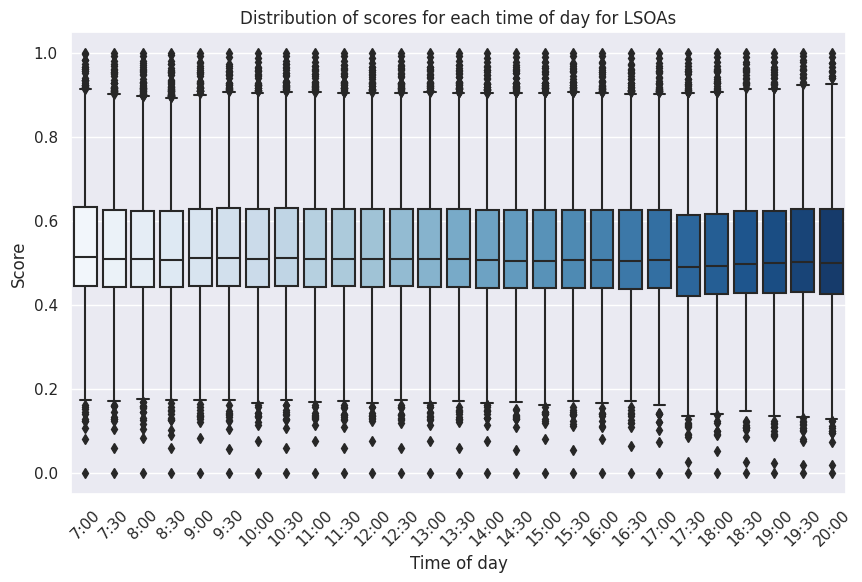

In [ ]:
sns.set(style="darkgrid")

# Create a copy of the DataFrame
all_scores_df_copy = df_scores.copy()

all_scores_df_copy = all_scores_df_copy.drop(columns=['score'])

# Convert column names to integers, sort, and then convert back to strings
all_scores_df_copy.columns = all_scores_df_copy.columns.astype(int)
all_scores_df_copy = all_scores_df_copy.sort_index(axis=1)

# Define time labels with integer keys
time_mapping = {
    700:'7:00', 730:'7:30', 800:'8:00', 830:'8:30', 900:'9:00', 930:'9:30', 1000:'10:00',
    1030:'10:30', 1100:'11:00', 1130:'11:30', 1200:'12:00', 1230:'12:30', 1300:'13:00',
    1330:'13:30', 1400:'14:00', 1430:'14:30', 1500:'15:00', 1530:'15:30', 1600:'16:00',
    1630:'16:30', 1700:'17:00', 1730:'17:30', 1800:'18:00', 1830:'18:30', 1900:'19:00',
    1930:'19:30', 2000:'20:00'
}

# Apply time mapping directly to columns
all_scores_df_copy.columns = [time_mapping[col] for col in all_scores_df_copy.columns]

# Boxplot for each time of day in numerical order
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_scores_df_copy, palette="Blues")
plt.title('Distribution of scores for each time of day for LSOAs')
plt.xlabel('Time of day')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()